In [ ]:
import glob
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision.models import vgg11
from torchvision.io import read_video
from torchvision import transforms
!pip install pytorchvideo
import pytorchvideo.transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import random
import cv2
import gc
import PIL
from google.colab.patches import cv2_imshow
import h5py

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


# Dataset

We use deep-soli dataset at the moment (https://github.com/simonwsw/deep-soli). Previosly, mmWave gesture dataset was used, but it was decided to use different one, as mmWave full version is inaccessable

Deep-soli dataset contains range-doppler maps of 11 gestures takes with google deep soli radar. It has 4 recievers. The dataset contains filtered range-doppler maps

In [ ]:
class VideoTransform(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, video):
        h, w = self.size
        L, C, H, W = video.size()
        rescaled_video = torch.FloatTensor(L, C, h, w)

        vid_mean = video.mean()
        vid_std = video.std()

        transform = transforms.Compose([
            transforms.Resize(self.size, antialias=True),
            transforms.Normalize(0, 1),
        ])

        for l in range(L):
            frame = video[l, :, :, :]
            frame = transform(frame)
            # plt.imshow(frame.permute(1, 2, 0))
            # plt.show()
            rescaled_video[l, :, :, :] = frame

        return rescaled_video


class GestureDataset(Dataset):
    # Based on https://github.com/fengxudi/mmWave-gesture-dataset

    def __init__(self):
        self.imgs_path = "/content/drive/MyDrive/Research project/mmWave-gesture-dataset/gesture_dataset/short_range_gesture/short_RangeDoppler/"

        folder_list = glob.glob(self.imgs_path + "*")
        print(folder_list)

        self.data = []
        classes = set()

        for class_path in folder_list:
            for video_path in glob.glob(class_path + "/*.mp4"):
                class_label = re.findall(r'short_RD_\d+_(\w+)_ \(\d+\).mp4', video_path)[0]
                self.data.append([video_path, class_label])
                classes.add(class_label)

        self.class_mapper = LabelEncoder()
        print(classes)
        self.class_mapper.fit([*classes])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_path, class_name = self.data[idx]

        # CNN requires dim (C, H, W)
        video, _, __ = read_video(video_path, output_format='TCHW', pts_unit='sec')

        video = video.float()
        video = VideoTransform((32, 32))(video)

        # Rotating video
        video = video.permute(0, 1, 3, 2)

        class_id = self.class_mapper.transform([class_name])
        class_id = torch.tensor(class_id)

        return video, class_id

class GestureDataset2(Dataset):
    # Based on https://github.com/simonwsw/deep-soli

    def __init__(self):
        self.imgs_path = "/content/drive/MyDrive/Research project/dsp/"

        self.data = []
        classes = set()

        video_paths = glob.glob(self.imgs_path + "*.h5")
        print(video_paths)

        for video_path in video_paths:
            class_label = re.findall(r'(\d+)_\d+_\d+.h5', video_path)[0]
            self.data.append([video_path, class_label])
            classes.add(class_label)

        self.class_mapper = LabelEncoder()
        print(classes)
        self.class_mapper.fit([*classes])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_path, class_name = self.data[idx]

        outputs = []

        with h5py.File(video_path, 'r') as f:
          for channel in range(3):
          # for channel in range(4):
            ch_data = f[f'ch{channel}']
            np_data = np.array(ch_data)
            np_data = np_data.reshape(-1, 32, 32)
            tensor_data = torch.from_numpy(np_data)
            outputs.append(tensor_data)

        video = torch.stack(outputs, dim=1)
        video = video.float()
         # Rotating video
        # video = video.permute(0, 1, 3, 2)
        video = VideoTransform((32, 32))(video)

        class_id = self.class_mapper.transform([class_name])
        class_id = torch.tensor(class_id)

        return video, class_id

# The model

It is quite popular to use CNN-RNN architectures for radar gesture recogntion. So we have 3 convolution layers with batch normalization and max pooling for feature extraction. And LSTM to learn temporal patterns

In [ ]:
class FeatureExtractor(torch.nn.Module):
    def __init__(self, in_features, out_features) -> None:
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_features, 32, 3)
        self.norm1 = torch.nn.BatchNorm2d(32)
        self.pool1 = torch.nn.MaxPool2d(2)

        self.conv2 = torch.nn.Conv2d(32, 64, 3)
        self.norm2 = torch.nn.BatchNorm2d(64)
        self.pool2 = torch.nn.MaxPool2d(2)

        self.conv3 = torch.nn.Conv2d(64, 128, 3)
        self.norm3 = torch.nn.BatchNorm2d(128)
        self.pool3 = torch.nn.MaxPool2d(2)

        self.conv4 = torch.nn.Conv2d(128, 256, 3)
        self.norm4 = torch.nn.BatchNorm2d(256)
        self.pool4 = torch.nn.MaxPool2d(2)

        self.relu = torch.nn.ReLU()
        self.flatten = torch.nn.Flatten()
        self.fc = torch.nn.Linear(512, out_features)
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x):

        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu(x)
        x = self.pool3(x)

        # x = self.conv4(x)
        # x = self.norm4(x)
        # x = self.relu(x)
        # x = self.pool4(x)

        x = self.flatten(x)
        x = self.fc(x)
        x = self.dropout(x)

        return x


class GestureNet(torch.nn.Module):
    def __init__(self, num_input_channels = 4, num_cnn_features=256, num_rnn_hidden_size=256, num_classes=7) -> None:
        super().__init__()

        self.num_rnn_hidden_size = num_rnn_hidden_size

        self.frame_model = FeatureExtractor(num_input_channels, num_cnn_features)
        # self.frame_model = vgg11()
        # first_conv_layer = [torch.nn.Conv2d(4, 3, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=True)]
        # first_conv_layer.extend(list(self.frame_model.features))

        # self.frame_model.features = torch.nn.Sequential(*first_conv_layer)
        # self.frame_model.classifier[6] = torch.nn.Linear(4096, num_cnn_features)

        self.temporal_model = torch.nn.LSTM(input_size=num_cnn_features, hidden_size=num_rnn_hidden_size)

        self.fc1 = torch.nn.Linear(num_rnn_hidden_size, num_rnn_hidden_size // 2)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(num_rnn_hidden_size // 2, num_classes)

    def forward(self, x):
        hidden = None

        for frame in x:
            features = self.frame_model(frame)
            features = torch.unsqueeze(features, 0)
            out, hidden = self.temporal_model(features, hidden)

        out = torch.squeeze(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        # out = torch.nn.Softmax(dim=1)(out)

        return out

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, loader, optimizer, scheduler, loss_func, device):
    losses = []
    model.train()

    for _, (frames, label) in enumerate(tqdm(loader)):
        optimizer.zero_grad()

        frames = frames.to(device)
        label = label.to(device)

        y_pred = model(frames)
        loss = loss_func(y_pred, label)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

    scheduler.step()

    return np.mean(losses)

def validate_model(model, loader, loss_func, device):
    losses = []
    acc = 0.0
    total = 0
    model.eval()

    labels = []
    predictions = []

    with torch.no_grad():
        for frames, label in tqdm(loader):
            frames = frames.to(device)
            label = label.to(device)

            y_pred = model(frames)

            loss = loss_func(y_pred, label)
            losses.append(loss.item())

            acc += sum(label == y_pred.argmax(dim=1)).item()
            total += len(label)

            labels.extend(label.detach().cpu().numpy())
            predictions.extend(y_pred.argmax(dim=1).detach().cpu().numpy())

    return np.mean(losses), acc / total, labels, predictions

def run_training(train_loader, val_loader, mapper, num_epochs=20, num_classes=12, model_postfix=''):
    model = GestureNet(num_input_channels=3, num_classes=num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, 0.1)
    loss_func = torch.nn.CrossEntropyLoss()

    model.to(device)

    best_state = model.state_dict()
    best_loss = 1000000
    best_epoch = 0

    for index in tqdm(range(num_epochs)):
        train_loss = train_model(model, train_loader, optimizer, scheduler, loss_func, device)
        val_loss, accuracy, labels, predictions = validate_model(model, val_loader, loss_func, device)

        if val_loss < best_loss:
            best_loss = val_loss
            best_state = model.state_dict()
            best_epoch = index

        print('\n', train_loss, val_loss, accuracy)
        yield (train_loss, val_loss, accuracy)

    model.load_state_dict(best_state)
    save_model(model, num_classes, num_epochs, is_finetune=False, postfix=model_postfix)
    loss, acc, labels, predictions = validate_model(model, val_loader, loss_func, device)

    print(f'Best epoch: {best_epoch}. Final loss: {loss}, acc: {acc}')

    cm = confusion_matrix(labels, predictions, normalize='all')
    ConfusionMatrixDisplay(cm, display_labels=mapper.classes_).plot(xticks_rotation=45)

def save_model(model, num_classes, num_epochs, is_finetune=False, postfix=''):
    core_path = "/content/drive/MyDrive/Research project/models"
    path = f"{core_path}/trained_model_{'finetune' if is_finetune else 'pre-train'}_{num_classes}cl_{num_epochs}ep{postfix}.pt"
    torch.save(model, path)


def visualize_stats(losses):
    _, axs = plt.subplots(3, figsize=(10, 18))
    indices = np.arange(1, len(losses) + 1, 1)

    axs[0].plot(indices, [train_loss for train_loss, _, _ in losses])
    axs[0].set_title('Train loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].grid(axis='y', linewidth=0.4)
    axs[0].set(frame_on=False)

    axs[1].plot(indices, [val_loss for _, val_loss, _ in losses])
    axs[1].set_title('Validation loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].grid(axis='y', linewidth=0.4)
    axs[1].set(frame_on=False)

    axs[2].plot(indices, [acc * 100 for _, _, acc in losses])
    axs[2].set_title('Validation accuracy')
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('Accuracy (%)')
    axs[2].grid(axis='y', linewidth=0.4)
    axs[2].set(frame_on=False)

    plt.show()


def visualize_sample(dataset, index=None):
    if index is None:
        index = random.randint(0, len(dataset))

    path, label = dataset.data[index]
    capture = cv2.VideoCapture(path)

    while capture.isOpened():
        ret, frame = capture.read()

        if ret:
            # cv2.imshow(f'Action {label}', frame)
            cv2_imshow(frame)
        else:
            capture.set(cv2.CAP_PROP_POS_FRAMES, 0)
            continue

        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

    capture.release()
    cv2.destroyAllWindows()


def collate_func(batch):
    data, labels = zip(*batch)

    labels = torch.tensor(labels)
    data = torch.nn.utils.rnn.pad_sequence(data)

    return data, labels


In [ ]:
# Assuring repproducibility
torch.manual_seed(123)
np.random.seed(123)
random.seed(123)

# Pre-training model

In [ ]:
# dataset = GestureDataset2()
# train_dataset, val_dataset = random_split(dataset, [0.7, 0.3])

# train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, collate_fn=collate_func)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, collate_fn=collate_func)

# # visualize_sample(dataset)

# losses = list(run_training(train_loader, val_loader, dataset.class_mapper))
# visualize_stats(losses)

# Transfer learning part

Using trained model to fine-tune it to the custom gestures that we recorded

In [ ]:
class CustomGestureDataset(Dataset):
    def __init__(self, ignored_labels=None, transforms=None):
        self.imgs_path = "/content/drive/MyDrive/Research project/preprocessed_dataset"
        self.encoder_path = "/content/drive/MyDrive/Research project/encoders"

        self.transforms = transforms

        self.data = []
        classes = set()

        folder_paths = glob.glob(self.imgs_path + "/*")

        for folder_path in folder_paths:
            for video_path in glob.glob(folder_path + f"/*.npy"):
              class_label = re.findall(r'\/([\w_-]*)\/[\d_]*.npy', video_path)[0]

              if ignored_labels is None or class_label not in ignored_labels:
                self.data.append([video_path, class_label])
                classes.add(class_label)

        self.class_mapper = LabelEncoder()
        print(classes)
        self.class_mapper.fit([*classes])
        path = f'{self.encoder_path}/encoder_{len(self.class_mapper.classes_)}.npy'
        np.save(path, self.class_mapper.classes_)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_path, class_name = self.data[idx]

        video = np.load(video_path)
        # video = np.expand_dims(video, 0)

        class_id = self.class_mapper.transform([class_name])
        class_id = torch.tensor(class_id)

        if self.transforms is not None:
            video = self.transforms(video)

        return video, class_id

In [ ]:
class FinetuneGestureNet(GestureNet):
  def __init__(self, num_classes, freeze_weights=False, weights_path="/content/drive/MyDrive/Research project/models/trained_model_pre-train_12cl_20ep.pt"):
    super().__init__(num_input_channels=3, num_classes=12)

    self.load_state_dict(torch.load(weights_path).state_dict())

    if freeze_weights:
      for param in self.parameters():
          param.requires_grad = False

    self.fc2 = torch.nn.Sequential(
        torch.nn.Linear(self.num_rnn_hidden_size // 2, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, num_classes)
    )
    # self.fc2 = torch.nn.Linear(self.num_rnn_hidden_size // 2, num_classes)

In [ ]:
def run_transfer_learning(train_loader, val_loader, mapper, num_classes, num_epochs=25, freeze_weights=False, model_postfix=''):
    model = FinetuneGestureNet(num_classes=num_classes, freeze_weights=freeze_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 30, 0.1)
    loss_func = torch.nn.CrossEntropyLoss()

    model.to(device)

    best_state = model.state_dict()
    best_loss = 1000000
    best_epoch = 0

    for index in tqdm(range(num_epochs)):
        train_loss = train_model(model, train_loader, optimizer, scheduler, loss_func, device)
        val_loss, accuracy, labels, predictions = validate_model(model, val_loader, loss_func, device)

        if val_loss < best_loss:
            best_loss = val_loss
            best_state = model.state_dict()
            best_epoch = index

        print('\n', train_loss, val_loss, accuracy)
        yield (train_loss, val_loss, accuracy)

    model.load_state_dict(best_state)
    save_model(model, num_classes, num_epochs, is_finetune=True, postfix=model_postfix)
    loss, acc, labels, predictions = validate_model(model, val_loader, loss_func, device)

    print(f'Best epoch: {best_epoch}. Final loss: {loss}, acc: {acc}')

    cm = confusion_matrix(labels, predictions, normalize='all')
    ConfusionMatrixDisplay(cm, display_labels=mapper.classes_).plot(xticks_rotation=45)
    plt.title("Confusion Matrix for the validation dataset")

def transfer_collate_func(batch):
    data, labels = zip(*batch)

    video_transforms = transforms.Compose([

      # pytorchvideo.transforms.UniformCropVideo(size=32),
      # pytorchvideo.transforms.Normalize(mean=0, std=1),
      # transforms.RandomErasing(scale=(0.01, 0.1), ratio=(0.01, 0.1)),
      #  pytorchvideo.transforms.UniformTemporalSubsample(3),
      # pytorchvideo.transforms.AugMix()

    ])

    # Doesn't work for batch of 1 size
    labels = torch.tensor(labels)
    data = [video_transforms(torch.tensor(sequence).float()) for sequence in data]
    data = torch.nn.utils.rnn.pad_sequence(data)

    return data, labels

{'palm_hold', 'finger_rub', 'push', 'swipe', 'finger_circle', 'no-action', 'pull'}


100%|██████████| 15/15 [00:03<00:00,  4.42it/s]

  4%|▍         | 1/25 [00:04<01:43,  4.31s/it]


 1.9104322989781697 1.8771692514419556 0.42857142857142855



100%|██████████| 15/15 [00:06<00:00,  2.30it/s]

  8%|▊         | 2/25 [00:11<02:21,  6.15s/it]


 1.8562594811121622 1.840865182876587 0.4142857142857143



100%|██████████| 15/15 [00:04<00:00,  3.25it/s]

 12%|█▏        | 3/25 [00:17<02:10,  5.91s/it]


 1.787484335899353 1.7328547239303589 0.5



100%|██████████| 15/15 [00:07<00:00,  2.11it/s]

 16%|█▌        | 4/25 [00:25<02:23,  6.81s/it]


 1.7071310917536417 1.6504901885986327 0.5285714285714286



100%|██████████| 15/15 [00:03<00:00,  3.83it/s]

 20%|██        | 5/25 [00:30<01:59,  5.96s/it]


 1.602429493268331 1.510706353187561 0.6857142857142857



100%|██████████| 15/15 [00:02<00:00,  5.00it/s]

 24%|██▍       | 6/25 [00:33<01:38,  5.18s/it]


 1.479960290590922 1.411198091506958 0.6285714285714286



100%|██████████| 15/15 [00:02<00:00,  5.29it/s]

 28%|██▊       | 7/25 [00:37<01:22,  4.58s/it]


 1.3437811295191446 1.2499322891235352 0.7428571428571429



100%|██████████| 15/15 [00:02<00:00,  5.38it/s]

 32%|███▏      | 8/25 [00:40<01:10,  4.18s/it]


 1.2004396677017213 1.15774667263031 0.7571428571428571



100%|██████████| 15/15 [00:02<00:00,  5.24it/s]

 36%|███▌      | 9/25 [00:43<01:02,  3.93s/it]


 1.0732741594314574 1.057871448993683 0.6285714285714286



100%|██████████| 15/15 [00:03<00:00,  4.44it/s]

 40%|████      | 10/25 [00:47<00:58,  3.92s/it]


 0.9547522664070129 0.9690444588661193 0.7571428571428571



100%|██████████| 15/15 [00:02<00:00,  5.43it/s]

 44%|████▍     | 11/25 [00:50<00:52,  3.73s/it]


 0.8683377265930176 0.8880640745162964 0.7285714285714285



100%|██████████| 15/15 [00:02<00:00,  5.40it/s]

 48%|████▊     | 12/25 [00:54<00:46,  3.59s/it]


 0.8118979473908742 0.8418388128280639 0.7857142857142857



100%|██████████| 15/15 [00:02<00:00,  5.43it/s]

 52%|█████▏    | 13/25 [00:57<00:42,  3.54s/it]


 0.7188464164733886 0.8272552967071534 0.8



100%|██████████| 15/15 [00:03<00:00,  4.56it/s]

 56%|█████▌    | 14/25 [01:01<00:39,  3.62s/it]


 0.6472030878067017 0.7062905132770538 0.7428571428571429



100%|██████████| 15/15 [00:02<00:00,  5.44it/s]

 60%|██████    | 15/25 [01:04<00:35,  3.51s/it]


 0.6151446223258972 0.8365751266479492 0.8428571428571429



100%|██████████| 15/15 [00:02<00:00,  5.39it/s]

 64%|██████▍   | 16/25 [01:07<00:31,  3.46s/it]


 0.5584725578625996 0.6723283529281616 0.7571428571428571



100%|██████████| 15/15 [00:03<00:00,  4.70it/s]

 68%|██████▊   | 17/25 [01:11<00:28,  3.58s/it]


 0.5109301964441936 0.5687646448612214 0.8142857142857143



100%|██████████| 15/15 [00:02<00:00,  5.14it/s]

 72%|███████▏  | 18/25 [01:15<00:24,  3.53s/it]


 0.4688938061396281 0.6033422768115997 0.8285714285714286



100%|██████████| 15/15 [00:02<00:00,  5.41it/s]

 76%|███████▌  | 19/25 [01:18<00:20,  3.44s/it]


 0.42538802822430927 0.554132056236267 0.8



100%|██████████| 15/15 [00:02<00:00,  5.59it/s]

 80%|████████  | 20/25 [01:21<00:16,  3.37s/it]


 0.40615626275539396 0.47658888101577757 0.7571428571428571



100%|██████████| 15/15 [00:03<00:00,  4.48it/s]

 84%|████████▍ | 21/25 [01:25<00:14,  3.54s/it]


 0.3534240772326787 0.36974809467792513 0.8



100%|██████████| 15/15 [00:02<00:00,  5.71it/s]

 88%|████████▊ | 22/25 [01:28<00:10,  3.41s/it]


 0.33424784044424694 0.5325713753700256 0.8428571428571429



100%|██████████| 15/15 [00:02<00:00,  5.40it/s]

 92%|█████████▏| 23/25 [01:32<00:06,  3.38s/it]


 0.3167884270350138 0.463125205039978 0.8571428571428571



100%|██████████| 15/15 [00:02<00:00,  5.64it/s]

 96%|█████████▌| 24/25 [01:35<00:03,  3.32s/it]


 0.3337574074665705 0.45787165462970736 0.8571428571428571



100%|██████████| 15/15 [00:03<00:00,  4.41it/s]

100%|██████████| 25/25 [01:39<00:00,  3.97s/it]



 0.27655816078186035 0.42919146418571474 0.8428571428571429


100%|██████████| 5/5 [00:00<00:00, 10.86it/s]


Best epoch: 20. Final loss: 0.6703714609146119, acc: 0.8


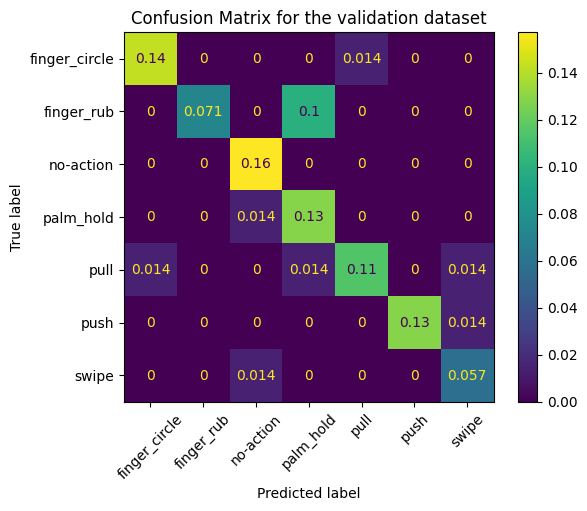

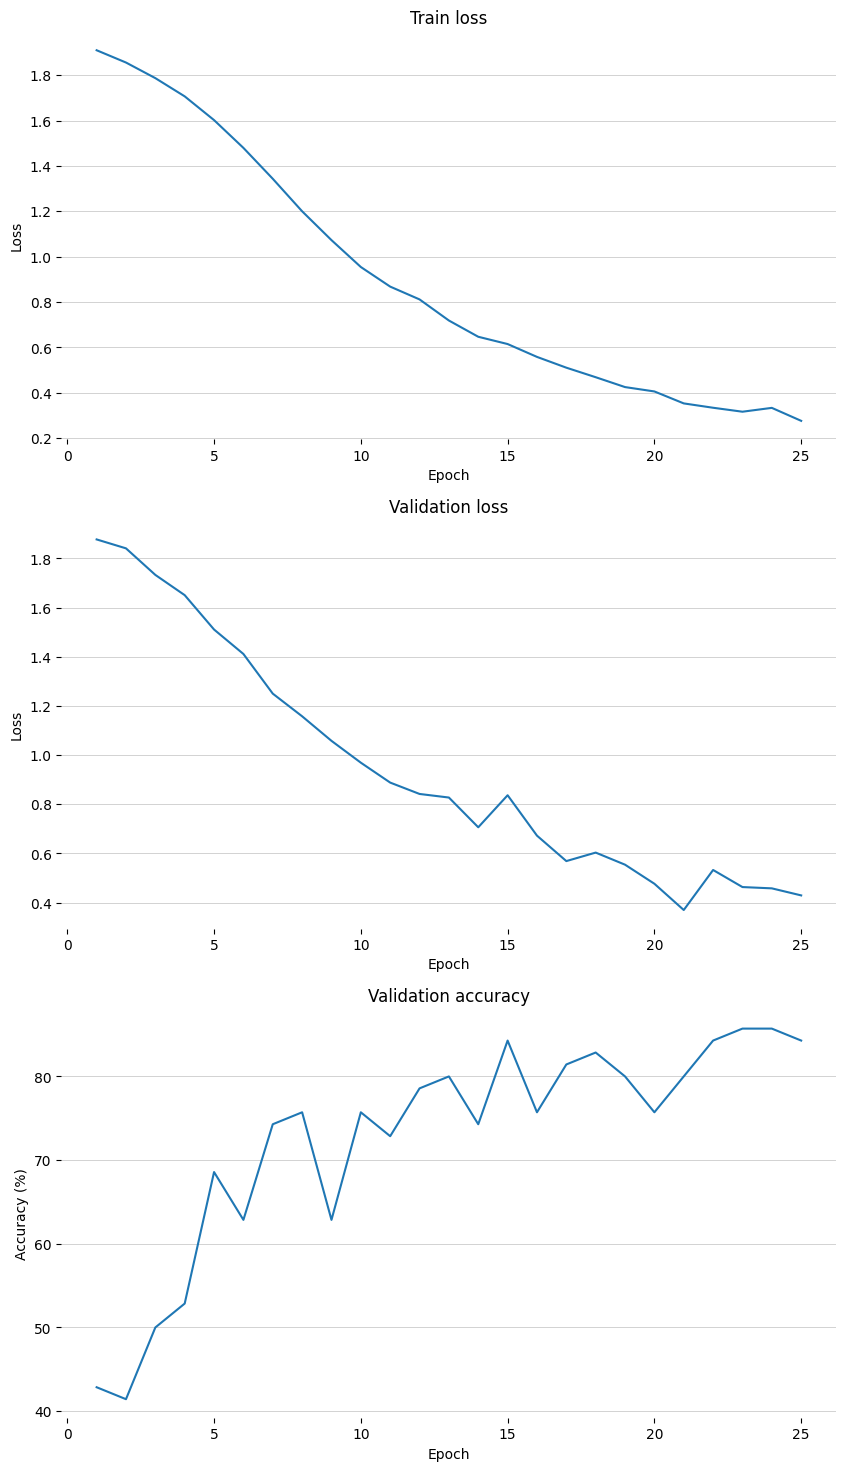

In [ ]:
dataset = CustomGestureDataset()

torch.manual_seed(123)
train_dataset, val_dataset = random_split(dataset, [0.8, 0.2])

train_loader = DataLoader(train_dataset, batch_size=19, shuffle=True, collate_fn=transfer_collate_func)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, collate_fn=transfer_collate_func)

losses = list(run_transfer_learning(train_loader, val_loader, dataset.class_mapper,
                                    num_classes=len(dataset.class_mapper.classes_)))
visualize_stats(losses)

## Tranining with class balance split

{'palm_hold', 'finger_rub', 'push', 'swipe', 'finger_circle', 'no-action', 'pull'}


100%|██████████| 15/15 [00:03<00:00,  4.82it/s]

  4%|▍         | 1/25 [00:03<01:26,  3.59s/it]


 1.939061951637268 1.9127941131591797 0.14285714285714285



100%|██████████| 15/15 [00:03<00:00,  4.99it/s]

  8%|▊         | 2/25 [00:07<01:23,  3.61s/it]


 1.8809745073318482 1.854498839378357 0.21428571428571427



100%|██████████| 15/15 [00:05<00:00,  2.93it/s]

 12%|█▏        | 3/25 [00:13<01:42,  4.65s/it]


 1.825922187169393 1.8119260549545289 0.2857142857142857



100%|██████████| 15/15 [00:05<00:00,  2.95it/s]

 16%|█▌        | 4/25 [00:19<01:48,  5.16s/it]


 1.762522554397583 1.750017261505127 0.42857142857142855



100%|██████████| 15/15 [00:07<00:00,  2.07it/s]

 20%|██        | 5/25 [00:27<02:04,  6.25s/it]


 1.6795322179794312 1.6830967664718628 0.4714285714285714



100%|██████████| 15/15 [00:04<00:00,  3.01it/s]

 24%|██▍       | 6/25 [00:32<01:53,  6.00s/it]


 1.5830870072046916 1.5815680265426635 0.5428571428571428



100%|██████████| 15/15 [00:03<00:00,  4.40it/s]

 28%|██▊       | 7/25 [00:36<01:35,  5.33s/it]


 1.475320823987325 1.4463896036148072 0.5428571428571428



100%|██████████| 15/15 [00:02<00:00,  5.30it/s]

 32%|███▏      | 8/25 [00:40<01:19,  4.70s/it]


 1.3489844957987467 1.335751724243164 0.6428571428571429



100%|██████████| 15/15 [00:02<00:00,  5.46it/s]

 36%|███▌      | 9/25 [00:43<01:07,  4.25s/it]


 1.2060828963915506 1.1876559734344483 0.6714285714285714



100%|██████████| 15/15 [00:02<00:00,  5.41it/s]

 40%|████      | 10/25 [00:46<00:59,  4.00s/it]


 1.073784351348877 1.0824622869491578 0.7857142857142857



100%|██████████| 15/15 [00:03<00:00,  4.63it/s]

 44%|████▍     | 11/25 [00:50<00:54,  3.92s/it]


 0.9718926628430684 0.9573614120483398 0.7571428571428571



100%|██████████| 15/15 [00:02<00:00,  5.48it/s]

 48%|████▊     | 12/25 [00:53<00:48,  3.71s/it]


 0.8340540488560995 0.7631956100463867 0.8571428571428571



100%|██████████| 15/15 [00:02<00:00,  5.38it/s]

 52%|█████▏    | 13/25 [00:56<00:42,  3.58s/it]


 0.714453379313151 0.8057132124900818 0.8142857142857143



100%|██████████| 15/15 [00:03<00:00,  4.97it/s]

 56%|█████▌    | 14/25 [01:00<00:39,  3.60s/it]


 0.6323062737782796 0.627309238910675 0.8714285714285714



100%|██████████| 15/15 [00:03<00:00,  4.99it/s]

 60%|██████    | 15/25 [01:04<00:35,  3.58s/it]


 0.5466267764568329 0.6419417858123779 0.8142857142857143



100%|██████████| 15/15 [00:02<00:00,  5.47it/s]

 64%|██████▍   | 16/25 [01:07<00:31,  3.49s/it]


 0.45572635928789773 0.6405883848667144 0.8142857142857143



100%|██████████| 15/15 [00:02<00:00,  5.49it/s]

 68%|██████▊   | 17/25 [01:10<00:27,  3.42s/it]


 0.415612522761027 0.5948441684246063 0.7857142857142857



100%|██████████| 15/15 [00:03<00:00,  4.65it/s]

 72%|███████▏  | 18/25 [01:14<00:24,  3.56s/it]


 0.352559174100558 0.46236281394958495 0.9



100%|██████████| 15/15 [00:02<00:00,  5.70it/s]

 76%|███████▌  | 19/25 [01:17<00:20,  3.45s/it]


 0.32671250998973844 0.3252147138118744 0.9142857142857143



100%|██████████| 15/15 [00:02<00:00,  5.38it/s]

 80%|████████  | 20/25 [01:21<00:17,  3.41s/it]


 0.30520188609759014 0.4360092759132385 0.8428571428571429



100%|██████████| 15/15 [00:02<00:00,  5.45it/s]

 84%|████████▍ | 21/25 [01:24<00:13,  3.38s/it]


 0.25159907539685566 0.2966774195432663 0.9142857142857143



100%|██████████| 15/15 [00:03<00:00,  4.24it/s]

 88%|████████▊ | 22/25 [01:28<00:10,  3.58s/it]


 0.21635441531737645 0.2457052782177925 0.9142857142857143



100%|██████████| 15/15 [00:02<00:00,  5.38it/s]

 92%|█████████▏| 23/25 [01:31<00:07,  3.51s/it]


 0.2031421919663747 0.5804843127727508 0.7571428571428571



100%|██████████| 15/15 [00:02<00:00,  5.45it/s]

 96%|█████████▌| 24/25 [01:35<00:03,  3.44s/it]


 0.18270725359519321 0.3326781839132309 0.9



100%|██████████| 15/15 [00:02<00:00,  5.44it/s]

100%|██████████| 25/25 [01:38<00:00,  3.94s/it]



 0.21855983237425486 0.21115809231996535 0.9428571428571428


100%|██████████| 5/5 [00:00<00:00,  8.83it/s]


Best epoch: 24. Final loss: 0.1961598739027977, acc: 0.9428571428571428


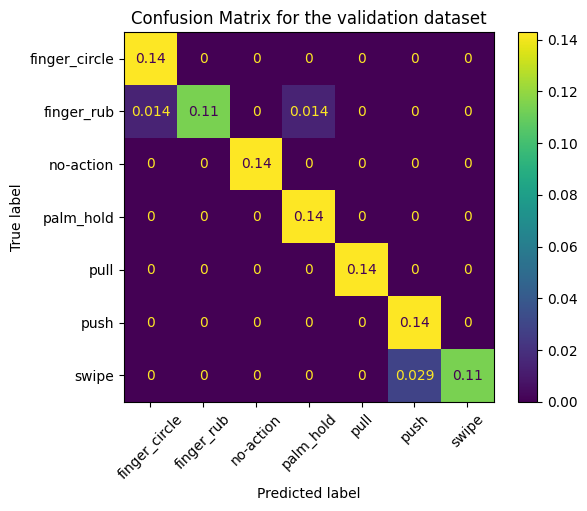

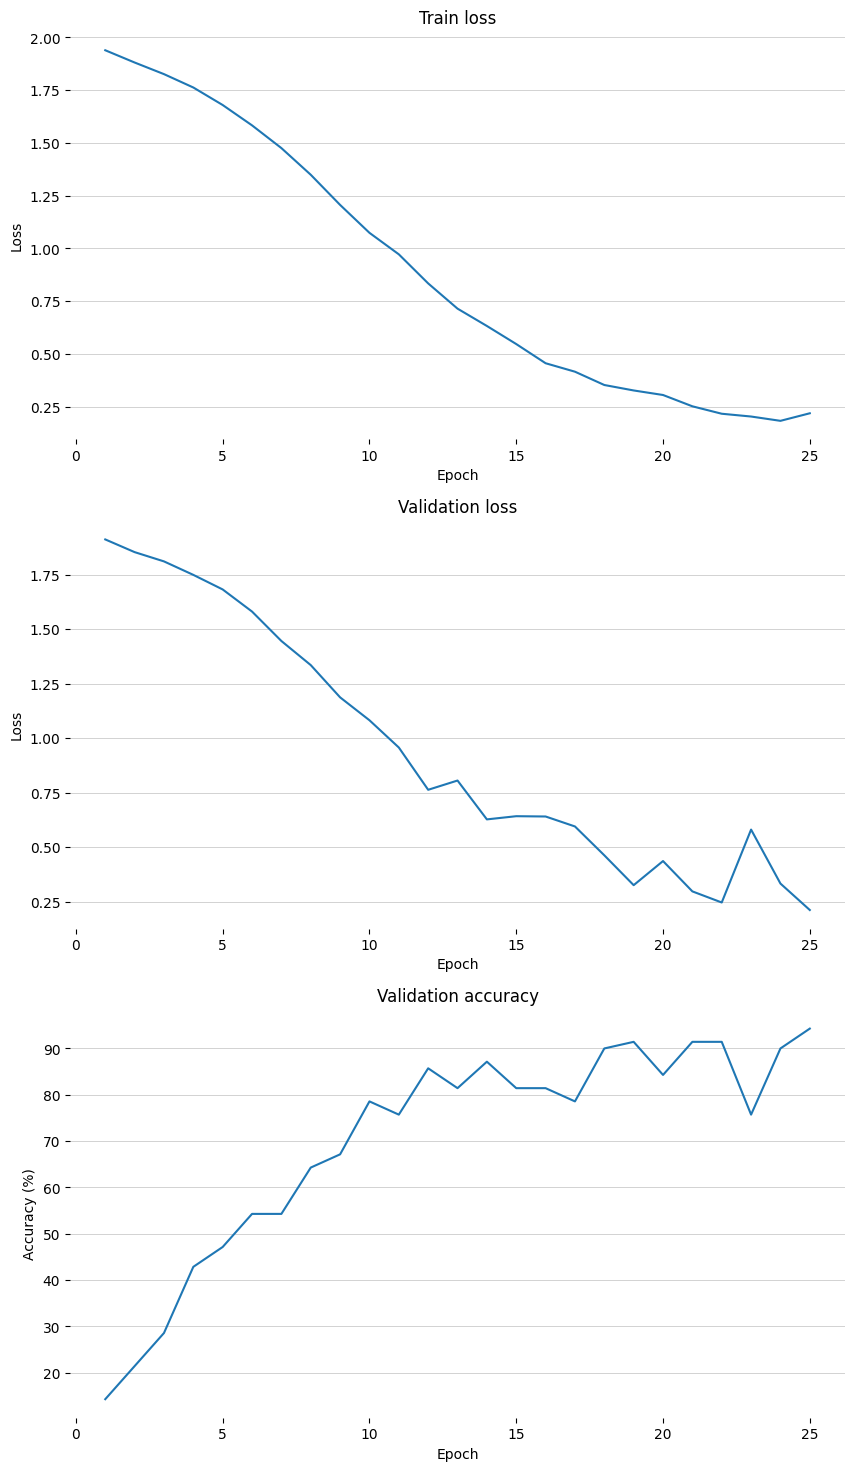

In [ ]:
def manual_split_class_balance(dataset, split_ratio=0.8):

    class_indices = get_class_indices(dataset)
    train_indices, test_indices = [], []

    for class_label, indices in class_indices.items():
        num_samples = len(indices)
        split_index = int(split_ratio * num_samples)

        shuffled_indices = torch.randperm(num_samples).tolist()
        shuffled_indices = [indices[ind] for ind in shuffled_indices]

        train_indices.extend(shuffled_indices[:split_index])
        test_indices.extend(shuffled_indices[split_index:])

    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    test_dataset = torch.utils.data.Subset(dataset, test_indices)

    return train_dataset, test_dataset

def get_class_indices(dataset):
    class_indices = {}
    for index in range(len(dataset)):
        _, label = dataset[index]
        if label.item() not in class_indices:
            class_indices[label.item()] = []
        class_indices[label.item()].append(index)

    return class_indices

dataset = CustomGestureDataset()
torch.manual_seed(123)
train_dataset, val_dataset = manual_split_class_balance(dataset)

train_loader = DataLoader(train_dataset, batch_size=19, shuffle=True, collate_fn=transfer_collate_func)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, collate_fn=transfer_collate_func)

losses = list(run_transfer_learning(train_loader, val_loader, dataset.class_mapper,
                                    num_classes=len(dataset.class_mapper.classes_), model_postfix='_custom_split'))
visualize_stats(losses)


## Training without no-action

{'palm_hold', 'finger_rub', 'push', 'swipe', 'finger_circle', 'pull'}


100%|██████████| 13/13 [00:01<00:00,  6.63it/s]

  4%|▍         | 1/25 [00:02<00:56,  2.34s/it]


 1.7793104098393366 1.7404341995716095 0.36666666666666664



100%|██████████| 13/13 [00:02<00:00,  6.12it/s]

  8%|▊         | 2/25 [00:04<00:57,  2.49s/it]


 1.7144297453073354 1.6887518763542175 0.5166666666666667



100%|██████████| 13/13 [00:02<00:00,  5.92it/s]

 12%|█▏        | 3/25 [00:07<00:55,  2.53s/it]


 1.6560721764197717 1.6386635899543762 0.38333333333333336



100%|██████████| 13/13 [00:01<00:00,  6.73it/s]

 16%|█▌        | 4/25 [00:09<00:51,  2.45s/it]


 1.5791764167638926 1.559739500284195 0.43333333333333335



100%|██████████| 13/13 [00:01<00:00,  6.73it/s]

 20%|██        | 5/25 [00:12<00:47,  2.39s/it]


 1.5000181748316839 1.4790071845054626 0.55



100%|██████████| 13/13 [00:01<00:00,  6.83it/s]

 24%|██▍       | 6/25 [00:14<00:44,  2.36s/it]


 1.4199992418289185 1.387050211429596 0.6833333333333333



100%|██████████| 13/13 [00:01<00:00,  6.70it/s]

 28%|██▊       | 7/25 [00:16<00:42,  2.38s/it]


 1.2965170603532057 1.266279399394989 0.75



100%|██████████| 13/13 [00:02<00:00,  5.35it/s]

 32%|███▏      | 8/25 [00:19<00:42,  2.52s/it]


 1.2145602794793935 1.1339523196220398 0.7833333333333333



100%|██████████| 13/13 [00:01<00:00,  6.81it/s]

 36%|███▌      | 9/25 [00:21<00:39,  2.44s/it]


 1.058095565209022 0.9993979930877686 0.8333333333333334



100%|██████████| 13/13 [00:01<00:00,  6.81it/s]

 40%|████      | 10/25 [00:24<00:35,  2.40s/it]


 0.9372457128304702 0.8885568231344223 0.7833333333333333



100%|██████████| 13/13 [00:01<00:00,  6.97it/s]

 44%|████▍     | 11/25 [00:26<00:32,  2.35s/it]


 0.791727717106159 0.7208211272954941 0.8833333333333333



100%|██████████| 13/13 [00:01<00:00,  6.88it/s]

 48%|████▊     | 12/25 [00:28<00:30,  2.33s/it]


 0.6426045161027175 0.6144919693470001 0.8333333333333334



100%|██████████| 13/13 [00:02<00:00,  5.51it/s]

 52%|█████▏    | 13/25 [00:31<00:29,  2.50s/it]


 0.5042276886793283 0.4932677522301674 0.8833333333333333



100%|██████████| 13/13 [00:02<00:00,  6.37it/s]

 56%|█████▌    | 14/25 [00:34<00:27,  2.47s/it]


 0.4005396274419931 0.425307534635067 0.9166666666666666



100%|██████████| 13/13 [00:01<00:00,  6.79it/s]

 60%|██████    | 15/25 [00:36<00:24,  2.42s/it]


 0.3786312777262468 0.3472267612814903 0.95



100%|██████████| 13/13 [00:01<00:00,  6.73it/s]

 64%|██████▍   | 16/25 [00:38<00:21,  2.39s/it]


 0.2532521669681256 0.3135385885834694 0.95



100%|██████████| 13/13 [00:01<00:00,  6.62it/s]

 68%|██████▊   | 17/25 [00:41<00:19,  2.38s/it]


 0.2190148658477343 0.25123225152492523 0.95



100%|██████████| 13/13 [00:02<00:00,  5.74it/s]

 72%|███████▏  | 18/25 [00:43<00:17,  2.50s/it]


 0.17260364958873162 0.24339193850755692 0.95



100%|██████████| 13/13 [00:02<00:00,  5.96it/s]

 76%|███████▌  | 19/25 [00:46<00:15,  2.52s/it]


 0.14955400217037934 0.20146988425403833 0.95



100%|██████████| 13/13 [00:01<00:00,  6.72it/s]

 80%|████████  | 20/25 [00:48<00:12,  2.46s/it]


 0.112358729999799 0.22342726588249207 0.9333333333333333



100%|██████████| 13/13 [00:01<00:00,  6.75it/s]

 84%|████████▍ | 21/25 [00:51<00:09,  2.42s/it]


 0.10672207864431235 0.16142467316240072 0.9666666666666667



100%|██████████| 13/13 [00:01<00:00,  6.81it/s]

 88%|████████▊ | 22/25 [00:53<00:07,  2.38s/it]


 0.11021333717955993 0.17517532594501972 0.95



100%|██████████| 13/13 [00:02<00:00,  6.34it/s]

 92%|█████████▏| 23/25 [00:55<00:04,  2.43s/it]


 0.1048735764164191 0.17360871471464634 0.9666666666666667



100%|██████████| 13/13 [00:02<00:00,  5.61it/s]

 96%|█████████▌| 24/25 [00:58<00:02,  2.51s/it]


 0.1088104836929303 0.13639901112765074 0.95



100%|██████████| 13/13 [00:01<00:00,  6.75it/s]

100%|██████████| 25/25 [01:00<00:00,  2.43s/it]



 0.21011652883428794 0.138028378598392 0.9666666666666667


100%|██████████| 4/4 [00:00<00:00, 11.14it/s]


Best epoch: 23. Final loss: 0.11835316754877567, acc: 0.9666666666666667


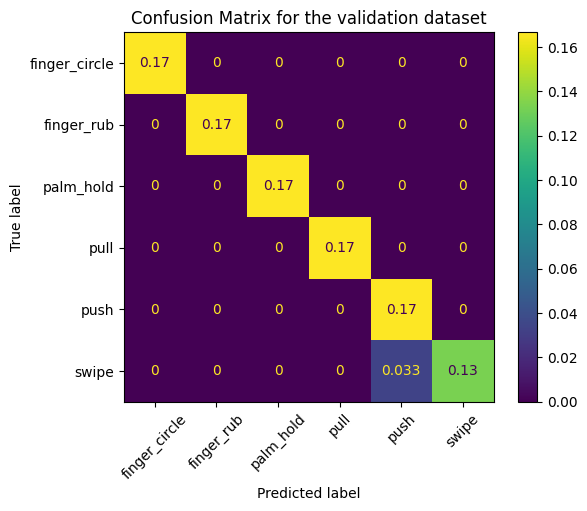

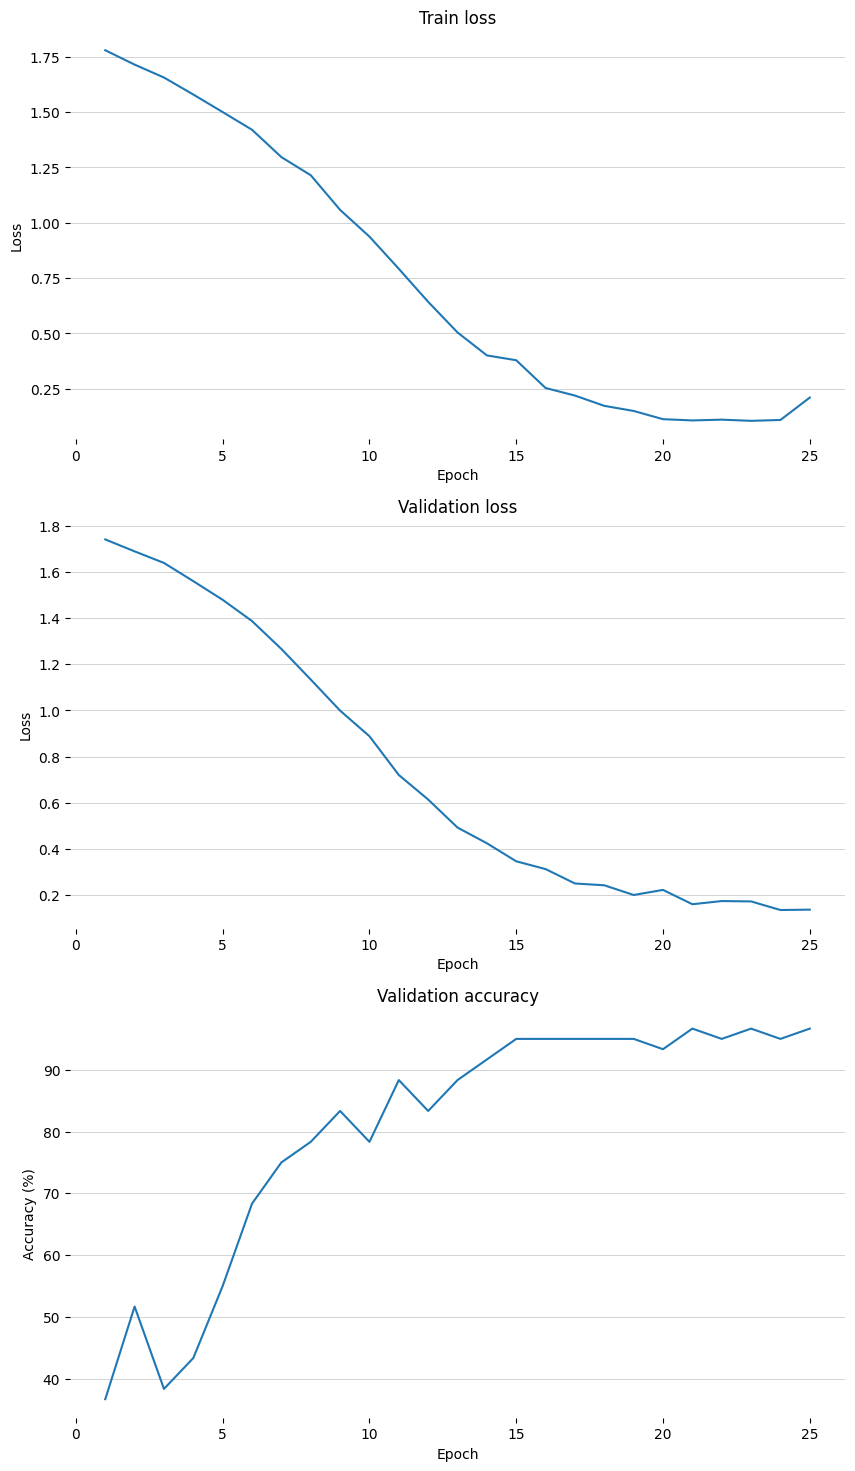

In [ ]:
dataset = CustomGestureDataset(ignored_labels=['no-action'])
train_dataset, val_dataset = manual_split_class_balance(dataset)

train_loader = DataLoader(train_dataset, batch_size=19, shuffle=True, collate_fn=transfer_collate_func)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, collate_fn=transfer_collate_func)

losses = list(run_transfer_learning(train_loader, val_loader, dataset.class_mapper,
                                    num_classes=len(dataset.class_mapper.classes_), model_postfix='_custom_split_no_action'))
visualize_stats(losses)

## Training freezing weights


{'palm_hold', 'finger_rub', 'push', 'swipe', 'finger_circle', 'no-action', 'pull'}


100%|██████████| 15/15 [00:02<00:00,  7.47it/s]

  4%|▍         | 1/25 [00:02<01:00,  2.51s/it]


 1.9653148094813029 1.9177102088928222 0.34285714285714286



100%|██████████| 15/15 [00:02<00:00,  7.50it/s]

  8%|▊         | 2/25 [00:05<00:57,  2.52s/it]


 1.9139374415079753 1.8896557807922363 0.34285714285714286



100%|██████████| 15/15 [00:02<00:00,  7.39it/s]

 12%|█▏        | 3/25 [00:07<00:55,  2.53s/it]


 1.877474880218506 1.862371563911438 0.37142857142857144



100%|██████████| 15/15 [00:02<00:00,  6.52it/s]

 16%|█▌        | 4/25 [00:10<00:56,  2.70s/it]


 1.8338884353637694 1.839776635169983 0.45714285714285713



100%|██████████| 15/15 [00:02<00:00,  7.27it/s]

 20%|██        | 5/25 [00:13<00:53,  2.66s/it]


 1.8024957338968912 1.8175995588302611 0.5714285714285714



100%|██████████| 15/15 [00:02<00:00,  7.49it/s]

 24%|██▍       | 6/25 [00:15<00:49,  2.62s/it]


 1.7618571758270263 1.7848761796951294 0.5428571428571428



100%|██████████| 15/15 [00:01<00:00,  7.53it/s]

 28%|██▊       | 7/25 [00:18<00:46,  2.58s/it]


 1.7211026668548584 1.7305991172790527 0.5714285714285714



100%|██████████| 15/15 [00:01<00:00,  7.52it/s]

 32%|███▏      | 8/25 [00:20<00:43,  2.56s/it]


 1.6790014902750652 1.6708513975143433 0.5428571428571428



100%|██████████| 15/15 [00:02<00:00,  6.34it/s]

 36%|███▌      | 9/25 [00:23<00:43,  2.70s/it]


 1.6193267901738484 1.6059406757354737 0.5285714285714286



100%|██████████| 15/15 [00:02<00:00,  7.10it/s]

 40%|████      | 10/25 [00:26<00:40,  2.68s/it]


 1.5739935398101808 1.5743093252182008 0.4714285714285714



100%|██████████| 15/15 [00:01<00:00,  7.74it/s]

 44%|████▍     | 11/25 [00:28<00:36,  2.60s/it]


 1.5060133695602418 1.489918828010559 0.5571428571428572



100%|██████████| 15/15 [00:01<00:00,  7.63it/s]

 48%|████▊     | 12/25 [00:31<00:33,  2.56s/it]


 1.4676348368326824 1.3975189924240112 0.6



100%|██████████| 15/15 [00:01<00:00,  7.70it/s]

 52%|█████▏    | 13/25 [00:33<00:30,  2.53s/it]


 1.419314153989156 1.4058544397354127 0.5571428571428572



100%|██████████| 15/15 [00:02<00:00,  6.27it/s]

 56%|█████▌    | 14/25 [00:36<00:29,  2.69s/it]


 1.3506335179011026 1.3210557222366333 0.5428571428571428



100%|██████████| 15/15 [00:02<00:00,  7.37it/s]

 60%|██████    | 15/25 [00:39<00:26,  2.65s/it]


 1.3259896039962769 1.2855426788330078 0.5285714285714286



100%|██████████| 15/15 [00:02<00:00,  7.44it/s]

 64%|██████▍   | 16/25 [00:41<00:23,  2.61s/it]


 1.2988110780715942 1.2772486925125122 0.6428571428571429



100%|██████████| 15/15 [00:01<00:00,  7.72it/s]

 68%|██████▊   | 17/25 [00:44<00:20,  2.56s/it]


 1.2511253515879313 1.2382586479187012 0.5428571428571428



100%|██████████| 15/15 [00:01<00:00,  7.61it/s]

 72%|███████▏  | 18/25 [00:46<00:17,  2.54s/it]


 1.1940678437550862 1.13787122964859 0.6



100%|██████████| 15/15 [00:02<00:00,  6.41it/s]

 76%|███████▌  | 19/25 [00:49<00:16,  2.67s/it]


 1.2016705910364787 1.1106183767318725 0.5714285714285714



100%|██████████| 15/15 [00:02<00:00,  7.37it/s]

 80%|████████  | 20/25 [00:52<00:13,  2.64s/it]


 1.1792685588200886 1.16865074634552 0.6142857142857143



100%|██████████| 15/15 [00:02<00:00,  7.34it/s]

 84%|████████▍ | 21/25 [00:54<00:10,  2.63s/it]


 1.1434439857800802 1.1474350571632386 0.6571428571428571



100%|██████████| 15/15 [00:01<00:00,  7.50it/s]

 88%|████████▊ | 22/25 [00:57<00:07,  2.59s/it]


 1.124525511264801 1.0894885420799256 0.6714285714285714



100%|██████████| 15/15 [00:02<00:00,  7.44it/s]

 92%|█████████▏| 23/25 [00:59<00:05,  2.59s/it]


 1.1313026428222657 0.9911388516426086 0.7142857142857143



100%|██████████| 15/15 [00:02<00:00,  6.11it/s]

 96%|█████████▌| 24/25 [01:02<00:02,  2.72s/it]


 1.0569551706314086 1.193785309791565 0.5



100%|██████████| 15/15 [00:01<00:00,  7.61it/s]

100%|██████████| 25/25 [01:05<00:00,  2.62s/it]



 1.0288667718569438 1.047747004032135 0.6285714285714286


100%|██████████| 5/5 [00:00<00:00,  9.88it/s]


Best epoch: 22. Final loss: 1.012488067150116, acc: 0.7


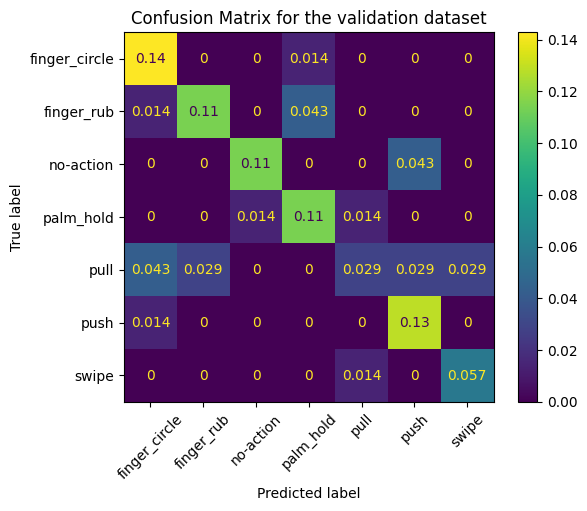

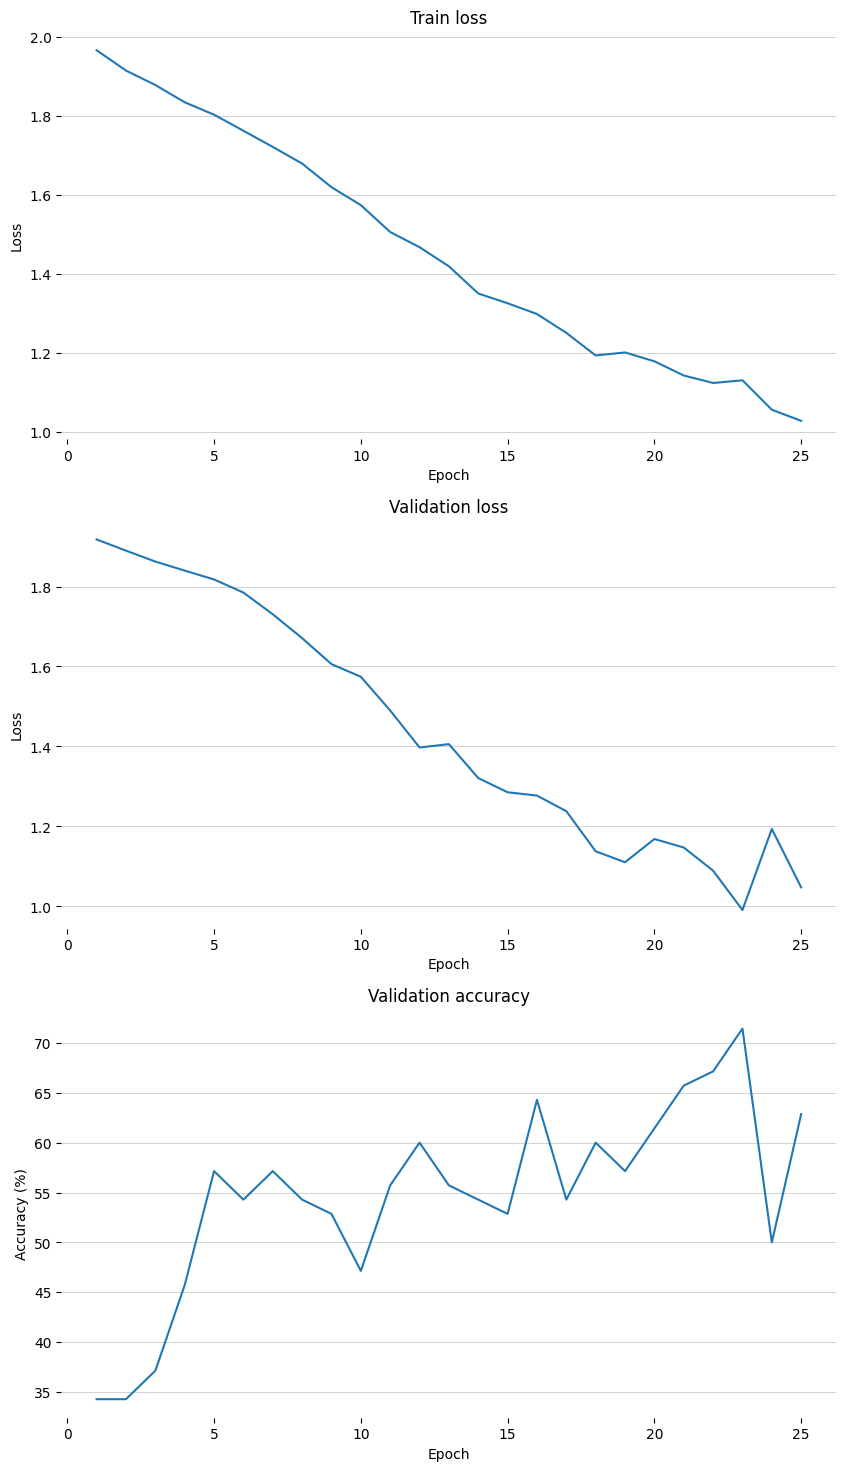

In [ ]:
dataset = CustomGestureDataset()

generator = torch.Generator().manual_seed(123)
train_dataset, val_dataset = random_split(dataset, [0.8, 0.2], generator)

train_loader = DataLoader(train_dataset, batch_size=19, shuffle=True, collate_fn=transfer_collate_func)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, collate_fn=transfer_collate_func)

losses = list(run_transfer_learning(train_loader, val_loader, dataset.class_mapper,
                                    freeze_weights=True, num_classes=len(dataset.class_mapper.classes_), model_postfix='_freezed_weights'))
visualize_stats(losses)

## Training without transfer learning

{'palm_hold', 'finger_rub', 'push', 'swipe', 'finger_circle', 'no-action', 'pull'}


100%|██████████| 14/14 [00:02<00:00,  5.21it/s]

  2%|▏         | 1/50 [00:03<02:36,  3.20s/it]


 1.8654376438685827 1.6574371576309204 0.2714285714285714



100%|██████████| 14/14 [00:02<00:00,  5.08it/s]

  4%|▍         | 2/50 [00:06<02:39,  3.32s/it]


 1.7705938901220049 1.6792215347290038 0.21428571428571427



100%|██████████| 14/14 [00:03<00:00,  4.43it/s]

  6%|▌         | 3/50 [00:10<02:43,  3.49s/it]


 1.7229233469281877 1.614732813835144 0.22857142857142856



100%|██████████| 14/14 [00:02<00:00,  5.26it/s]

  8%|▊         | 4/50 [00:13<02:34,  3.36s/it]


 1.6507339647838049 1.5678895235061645 0.21428571428571427



100%|██████████| 14/14 [00:02<00:00,  5.06it/s]

 10%|█         | 5/50 [00:16<02:30,  3.34s/it]


 1.6903300285339355 1.4721951484680176 0.2857142857142857



100%|██████████| 14/14 [00:03<00:00,  4.64it/s]

 12%|█▏        | 6/50 [00:20<02:31,  3.44s/it]


 1.7619116050856454 1.608491063117981 0.3142857142857143



100%|██████████| 14/14 [00:03<00:00,  4.66it/s]

 14%|█▍        | 7/50 [00:23<02:29,  3.47s/it]


 1.8024567195347376 1.6152148485183715 0.2857142857142857



100%|██████████| 14/14 [00:02<00:00,  5.08it/s]

 16%|█▌        | 8/50 [00:27<02:23,  3.41s/it]


 1.7843352811677116 1.6389601707458497 0.2714285714285714



100%|██████████| 14/14 [00:02<00:00,  5.16it/s]

 18%|█▊        | 9/50 [00:30<02:17,  3.36s/it]


 1.6777254343032837 1.4249558210372926 0.34285714285714286



100%|██████████| 14/14 [00:03<00:00,  4.39it/s]

 20%|██        | 10/50 [00:34<02:19,  3.49s/it]


 1.5182705010686601 1.8698451280593873 0.34285714285714286



100%|██████████| 14/14 [00:02<00:00,  5.20it/s]

 22%|██▏       | 11/50 [00:37<02:12,  3.40s/it]


 1.3915521885667528 1.3153946995735168 0.4857142857142857



100%|██████████| 14/14 [00:02<00:00,  5.22it/s]

 24%|██▍       | 12/50 [00:40<02:06,  3.33s/it]


 1.3720770903996058 2.0683571696281433 0.34285714285714286



100%|██████████| 14/14 [00:02<00:00,  5.09it/s]

 26%|██▌       | 13/50 [00:43<02:02,  3.32s/it]


 1.264979247535978 1.429006862640381 0.37142857142857144



100%|██████████| 14/14 [00:03<00:00,  4.11it/s]

 28%|██▊       | 14/50 [00:47<02:06,  3.50s/it]


 1.1201694820608412 1.269276201725006 0.3142857142857143



100%|██████████| 14/14 [00:02<00:00,  5.18it/s]

 30%|███       | 15/50 [00:51<01:59,  3.42s/it]


 1.0561873487063818 1.0770509839057922 0.6



100%|██████████| 14/14 [00:02<00:00,  5.06it/s]

 32%|███▏      | 16/50 [00:54<01:54,  3.37s/it]


 1.0149184891155787 1.3093470096588136 0.45714285714285713



100%|██████████| 14/14 [00:02<00:00,  4.96it/s]

 34%|███▍      | 17/50 [00:57<01:52,  3.42s/it]


 0.8441621150289264 0.9888567447662353 0.6428571428571429



100%|██████████| 14/14 [00:03<00:00,  4.66it/s]

 36%|███▌      | 18/50 [01:01<01:50,  3.46s/it]


 0.7973806985786983 0.8378338932991027 0.6285714285714286



100%|██████████| 14/14 [00:02<00:00,  5.39it/s]

 38%|███▊      | 19/50 [01:04<01:43,  3.35s/it]


 0.8209440112113953 1.0465911865234374 0.5



100%|██████████| 14/14 [00:02<00:00,  5.24it/s]

 40%|████      | 20/50 [01:07<01:39,  3.30s/it]


 0.632148978965623 0.9782224059104919 0.7142857142857143



100%|██████████| 14/14 [00:02<00:00,  4.73it/s]

 42%|████▏     | 21/50 [01:11<01:38,  3.39s/it]


 0.5722504960639136 1.125351071357727 0.6428571428571429



100%|██████████| 14/14 [00:02<00:00,  4.98it/s]

 44%|████▍     | 22/50 [01:14<01:34,  3.37s/it]


 0.4881600673709597 0.823510718345642 0.7



100%|██████████| 14/14 [00:02<00:00,  5.13it/s]

 46%|████▌     | 23/50 [01:17<01:30,  3.34s/it]


 0.49168687633105684 0.7264783501625061 0.8142857142857143



100%|██████████| 14/14 [00:02<00:00,  5.15it/s]

 48%|████▊     | 24/50 [01:21<01:26,  3.31s/it]


 0.5557087255375726 2.3098780035972597 0.5142857142857142



100%|██████████| 14/14 [00:02<00:00,  4.80it/s]

 50%|█████     | 25/50 [01:24<01:24,  3.39s/it]


 0.48950204253196716 0.8254153490066528 0.7



100%|██████████| 14/14 [00:02<00:00,  5.00it/s]

 52%|█████▏    | 26/50 [01:28<01:21,  3.38s/it]


 0.4869449883699417 0.7567542254924774 0.8285714285714286



100%|██████████| 14/14 [00:02<00:00,  5.28it/s]

 54%|█████▍    | 27/50 [01:31<01:16,  3.31s/it]


 0.421587918485914 1.0131588935852052 0.7285714285714285



100%|██████████| 14/14 [00:02<00:00,  5.14it/s]

 56%|█████▌    | 28/50 [01:34<01:12,  3.29s/it]


 0.44065914303064346 1.1844570815563202 0.6714285714285714



100%|██████████| 14/14 [00:03<00:00,  4.34it/s]

 58%|█████▊    | 29/50 [01:38<01:12,  3.45s/it]


 0.43798222712108065 2.305523180961609 0.5714285714285714



100%|██████████| 14/14 [00:02<00:00,  5.20it/s]

 60%|██████    | 30/50 [01:41<01:07,  3.37s/it]


 0.40519189834594727 1.1189693331718444 0.6142857142857143



100%|██████████| 14/14 [00:02<00:00,  5.21it/s]

 62%|██████▏   | 31/50 [01:44<01:03,  3.33s/it]


 0.3912313399570329 0.9654249787330628 0.6



100%|██████████| 14/14 [00:02<00:00,  5.09it/s]

 64%|██████▍   | 32/50 [01:47<00:59,  3.32s/it]


 0.4121056912200792 0.9322842121124267 0.6714285714285714



100%|██████████| 14/14 [00:03<00:00,  4.14it/s]

 66%|██████▌   | 33/50 [01:51<00:59,  3.49s/it]


 0.3645565403359277 0.7663807451725007 0.6428571428571429



100%|██████████| 14/14 [00:02<00:00,  5.18it/s]

 68%|██████▊   | 34/50 [01:55<00:54,  3.42s/it]


 0.32226236909627914 1.0446323156356812 0.6142857142857143



100%|██████████| 14/14 [00:02<00:00,  5.14it/s]

 70%|███████   | 35/50 [01:58<00:50,  3.37s/it]


 0.3244767284819058 0.8678170830011368 0.6714285714285714



100%|██████████| 14/14 [00:02<00:00,  4.92it/s]

 72%|███████▏  | 36/50 [02:01<00:47,  3.42s/it]


 0.3051864228078297 1.1079619944095611 0.6857142857142857



100%|██████████| 14/14 [00:03<00:00,  4.46it/s]

 74%|███████▍  | 37/50 [02:05<00:45,  3.49s/it]


 0.2655396727578981 1.3776124477386475 0.5857142857142857



100%|██████████| 14/14 [00:02<00:00,  5.16it/s]

 76%|███████▌  | 38/50 [02:08<00:40,  3.41s/it]


 0.30195602402091026 1.0272242367267608 0.6142857142857143



100%|██████████| 14/14 [00:02<00:00,  5.20it/s]

 78%|███████▊  | 39/50 [02:12<00:36,  3.36s/it]


 0.24484293162822723 0.7028377890586853 0.7571428571428571



100%|██████████| 14/14 [00:02<00:00,  4.86it/s]

 80%|████████  | 40/50 [02:15<00:34,  3.41s/it]


 0.23130956505026137 0.8115476250648499 0.6571428571428571



100%|██████████| 14/14 [00:02<00:00,  4.82it/s]

 82%|████████▏ | 41/50 [02:18<00:30,  3.42s/it]


 0.3152441584638187 1.6166586041450501 0.5714285714285714



100%|██████████| 14/14 [00:02<00:00,  5.42it/s]

 84%|████████▍ | 42/50 [02:22<00:26,  3.33s/it]


 0.23239917201655252 1.2235082983970642 0.6142857142857143



100%|██████████| 14/14 [00:02<00:00,  5.10it/s]

 86%|████████▌ | 43/50 [02:25<00:23,  3.31s/it]


 0.2088083294885499 0.5420353293418885 0.8571428571428571



100%|██████████| 14/14 [00:03<00:00,  4.31it/s]

 88%|████████▊ | 44/50 [02:29<00:20,  3.50s/it]


 0.2096083015203476 0.7010945916175843 0.7285714285714285



100%|██████████| 14/14 [00:02<00:00,  5.33it/s]

 90%|█████████ | 45/50 [02:32<00:16,  3.39s/it]


 0.2307847131575857 1.062716007232666 0.5428571428571428



100%|██████████| 14/14 [00:02<00:00,  5.07it/s]

 92%|█████████▏| 46/50 [02:35<00:13,  3.35s/it]


 0.21543063383017266 1.829939889907837 0.5571428571428572



100%|██████████| 14/14 [00:02<00:00,  5.34it/s]

 94%|█████████▍| 47/50 [02:38<00:09,  3.28s/it]


 0.20622389337846211 0.5517284452915192 0.8



100%|██████████| 14/14 [00:03<00:00,  4.26it/s]

 96%|█████████▌| 48/50 [02:42<00:06,  3.45s/it]


 0.22729073145559855 1.029794031381607 0.6857142857142857



100%|██████████| 14/14 [00:02<00:00,  5.25it/s]

 98%|█████████▊| 49/50 [02:45<00:03,  3.38s/it]


 0.22679721510836057 1.0585258245468139 0.5714285714285714



100%|██████████| 14/14 [00:02<00:00,  4.95it/s]

100%|██████████| 50/50 [02:49<00:00,  3.38s/it]



 0.2582481381084238 1.069680893421173 0.6571428571428571


100%|██████████| 5/5 [00:00<00:00, 10.65it/s]


Best epoch: 42. Final loss: 1.8699169993400573, acc: 0.6428571428571429


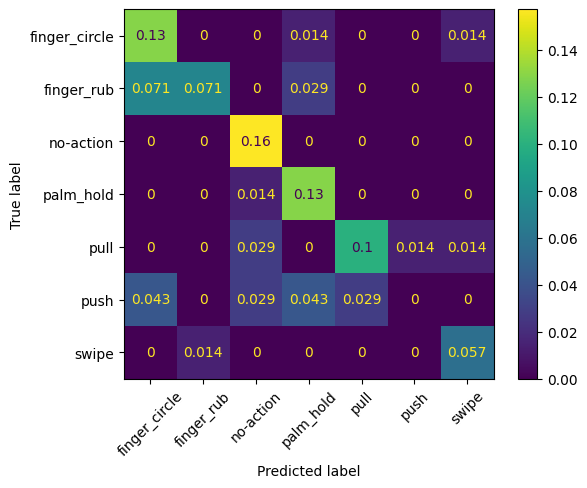

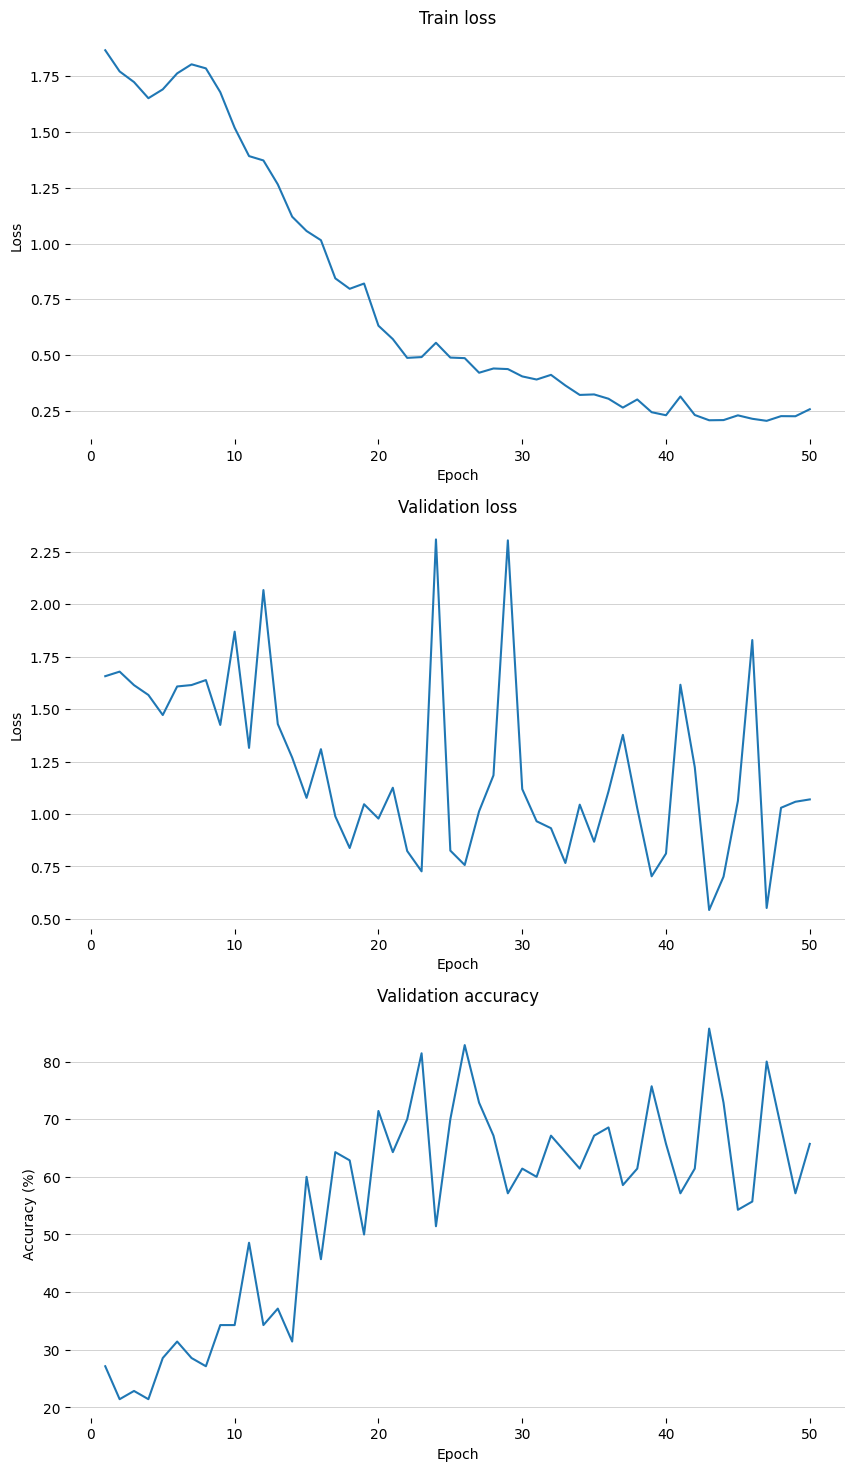

In [ ]:
dataset = CustomGestureDataset()
generator = torch.Generator().manual_seed(123)
train_dataset, val_dataset = random_split(dataset, [0.8, 0.2], generator)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, collate_fn=transfer_collate_func)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, collate_fn=transfer_collate_func)

losses = list(run_training(train_loader, val_loader, dataset.class_mapper,
                           num_classes=len(dataset.class_mapper.classes_), num_epochs=50, model_postfix='_no_pre_train'))
visualize_stats(losses)